# Alineamientos

Funcion para crear el dotplot.
(DUDA: EN EL GRAFICO DE LA CLASE SE VEÍA DIFERENTE CON UN EJEMPLO... CONSULTAR)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices


def show_dotplot(dotplot, k=0, show_values=False):
    plt.imshow(dotplot, cmap="gray_r", interpolation='nearest')
    if k!=0:
        k_message = f"k={k}"
    else:
        k_message = "SIN FILTRAR"
        
    if show_values:
        for i in range(len(dotplot)):
            for j in range(len(dotplot[0])):
                value = dotplot[i][j]
                plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='red', fontsize=8)

    plt.title(f'Dotplot: {len(dotplot)} elementos vs {len(dotplot[0])} elementos | {k_message}')
    
    plt.xlabel("Secuencia 2")
    plt.ylabel("Secuencia 1")
    plt.show()
    
def make_dotplot(seq1, seq2, t):
    dotplot = np.zeros((len(seq1),len(seq2)))
        
    for i in range(len(seq1)):
        for j in range(len(seq2)):
            if t=='ADN':
                if seq1[i]==seq2[j]:
                    dotplot[i,j] = 1
            else:
                dotplot[i,j] = substitution_matrices.load('BLOSUM62')[seq1[i],seq2[j]]
                    
    return dotplot

Funcion para filtrar el dotplot

In [22]:
def has_potential(subdotplot, threshold):
    score = 0
    for i in range(len(subdotplot)):
        score += subdotplot[i,i]

    if score > threshold:
        return True
    return False

def filtered_dotplot(dotplot, k, t, threshold):
    """
    Filtra una matriz de dotplot resaltando las regiones diagonales de tamaño k con mayor puntuación.
    
    La función evalúa las submatrices de tamaño `k x k` dentro de la matriz `dotplot`, buscando aquellas que tienen un número mayoritario de unos en su diagonal principal. Si la submatriz cumple con el criterio, se añade al dotplot filtrado.
    
    Args:
        dotplot (numpy.ndarray): La matriz original de dotplot que se analizará.
        k (int): El tamaño de la submatriz cuadrada a evaluar.
        t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
        threshold (int): Umbral mínimo para determinar si un alineamiento es válido. Representa la puntuación mínima necesaria para considerar un alineamiento como factible.
    Returns:
        numpy.ndarray: Una nueva matriz del mismo tamaño que `dotplot`, donde las regiones que cumplen con 
        el criterio están resaltadas con unos en la diagonal.
    
    Raises:
        ValueError: Si `k` es mayor que las dimensiones de la matriz `dotplot`.
    """
    rows, cols = len(dotplot), len(dotplot[0])
    f_dotplot = np.zeros((rows, cols))

    for i in range(rows-k+1):
        for j in range(cols-k+1):
            sub_dotplot = dotplot[i:i+k, j:j+k]
            if has_potential(sub_dotplot, threshold):
                if t=='ADN':
                    f_dotplot[i:i+k, j:j+k] = sub_dotplot * np.eye(k)
                elif t=='PROTEIN':
                    f_dotplot[i,j]=1

    return f_dotplot
            

Funcion para encontrar el mejor alineamiento posible... (una especie de greedy, hecho rapido, tiene muchos 'huecos')

In [23]:
def obtain_best_alignment(dotplot):
    complete = False
    alignment_list = []
    i = 0
    j = 0
    while not complete:
        if i >= len(dotplot) or j >= len(dotplot[0]):
            complete = True
        else:
            alignment_list.append([i, j])
            if i + 1 < len(dotplot) and j + 1 < len(dotplot[0]) and dotplot[i + 1, j + 1] == 1:
                i += 1
                j += 1
            elif j + 1 < len(dotplot[0]) and dotplot[i, j + 1] == 1:
                j += 1
            elif i + 1 < len(dotplot) and dotplot[i + 1, j] == 1:
                i += 1
            else:
                j += 1
    return alignment_list


Traduccion de la lista de alineamientos a una sintaxis mas amigable

In [24]:
def traduce_alignment(alignment_list, seq1, seq2):
    traduced_seq = ''
    for i in range(len(alignment_list)):
        if seq1[alignment_list[i][0]] == seq2[alignment_list[i][1]]:
                traduced_seq += f"{seq1[alignment_list[i][0]]}{i}"
        else:
            # traduced_seq += f"{seq1[alignment_list[i-1][0]]}"
            # Si se prefiere un guion en vez de repetir la ultima base:
            traduced_seq += "-"
    return traduced_seq
    

Funcion de alineamiento de secuencias

In [25]:
from Bio import SeqIO

def read_fasta(filename):
    with open(filename,'r') as handle:
        r_seq = list(SeqIO.parse(handle, 'fasta'))
        return r_seq[0].seq, r_seq[1].seq

In [52]:
def obtain_threshold(seq, t):
    t_dotplot = make_dotplot(seq, seq, t)
    i=0
    j=0
    threshold = 0
    while i < len(t_dotplot) and j < len(t_dotplot[0]):
        threshold += t_dotplot[i, j]
        i+=1
        j+=1
    threshold = threshold/len(seq)
    
    return threshold
    

In [26]:
def get_score(alignment, dotplot):
    score = 0.0
    for coord in alignment:
        score += dotplot[coord[0]][coord[1]]
    return score

In [59]:
def alignment(seq1, seq2, k, t, threshold=0):
    """
    Genera la mejor alineación entre dos secuencias utilizando un dotplot filtrado.
    
    Args:
        seq1 (str): Primera secuencia a alinear.
        seq2 (str): Segunda secuencia a alinear.
        k (int): Tamaño de las submatrices cuadradas utilizadas en el filtrado del dotplot.
        t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
    
    Returns:
        tuple: Una tupla que contiene la alineación traducida, el dotplot original, y el dotplot filtrado.
    
    Raises:
        ValueError: Si el tamaño `k` es mayor que las dimensiones de la matriz `dotplot`.
    """
    
    if t == 'ADN':
        threshold = (k/2)
    elif threshold==0:
        threshold = obtain_threshold(seq1, t)
        
    if k > len(seq1) or k > len(seq2):
        raise ValueError(f"El tamaño 'k' ({k}) es mayor que las dimensiones de la matriz dotplot.")

    dotplot = make_dotplot(seq1, seq2, t)
    f_dotplot = filtered_dotplot(dotplot, k, t, threshold)
    best_alignment = obtain_best_alignment(f_dotplot)
    traduced_alignment = traduce_alignment(best_alignment, seq1, seq2)
    if t == 'PROTEIN':
        score = get_score(best_alignment, dotplot)
        return traduced_alignment, dotplot, f_dotplot, score
    return traduced_alignment, dotplot, f_dotplot


In [60]:
file = "./documents/TP53.fna"
seq1, seq2 = read_fasta(file)
seq1, seq2 = seq1[:1000], seq2[:1000]

# Ventana de filtrado de alineamientos:
k = 30

align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN")

# seq1 = 'TACG'
# seq2 = 'TATCG'
# k = 3
# threshold = (k/2)
# align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN", threshold)

# RESULTADOS

#### Dotplot sin filtrar

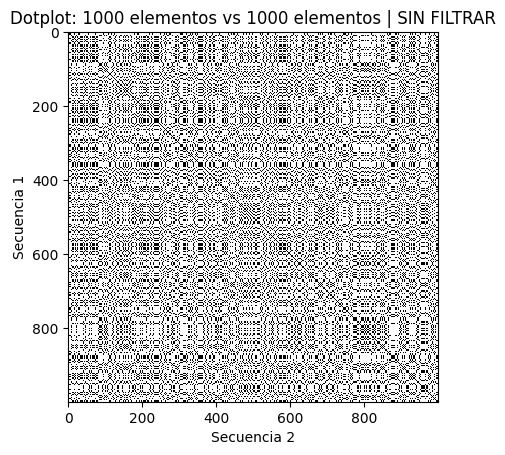

In [104]:
show_dotplot(dotplot)

#### Dotplot filtrado

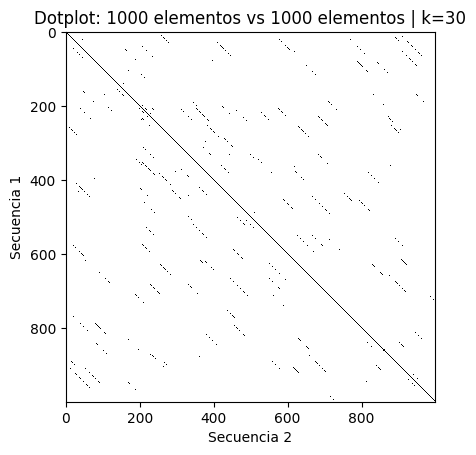

In [105]:
show_dotplot(f_dotplot, k)

#### Mejor alineamiento

In [106]:
print(align)

C0T1C2A3A4A5A6G7T8C9T10A11G12A13G14C15C16A17C18C19G20T21C22C23A24G25G26G27A28G29C30A31G32G33T34A35G36C37T38G39C40T41G42G43G44C45T46C47C48G49G50G51G52A53C54A55C56T57T58T59G60C61G62T63T64C65G66G67G68C69T70G71G72G73A74G75C76G77T78G79C80T81T82T83C84C85A86C87G88A89C90G91G92T93G94A95C96A97C98G99C100T101T102C103C104C105T106G107G108A109T110T111G112G113G114T115A116A117G118C119T120C121C122T123G124A125C126T127G128A129A130C131T132T133G134A135T136G137A138G139T140C141C142T143C144T145C146T147G148A149G150T151C152A153C154G155G156G157C158T159C160T161C162G163G164C165T166C167C168G169T170G171T172A173T174T175T176T177C178A179G180C181T182C183G184G185G186A187A188A189A190T191C192G193C194T195G196G197G198G199C200T201G202G203G204G205G206T207G208G209G210G211C212A213G214T215G216G217G218G219A220C221T222T223A224G225C226G227A228G229T230T231T232G233G234G235G236G237T238G239A240G241T242G243G244G245A246T247G248G249A250A251G252C253T254T255G256G257C258T259A260G261A262G263G264G265A266T267C268A269T270C271A272T273A274G275G276A2

### Comparación con Biopython

Función de alineamiento de biopython

In [107]:
from Bio import pairwise2

# Realizar el alineamiento
al = pairwise2.align.globalxx(seq1, seq2)

# Imprimir los alineamientos
for a in al:
    print(pairwise2.format_alignment(*a))

CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACGCTTCCCTGGATTGGGTAAGCTCCTGACTGAACTTGATGAGTCCTCTCTGAGTCACGGGCTCTCGGCTCCGTGTATTTTCAGCTCGGGAAAATCGCTGGGGCTGGGGGTGGGGCAGTGGGGACTTAGCGAGTTTGGGGGTGAGTGGGATGGAAGCTTGGCTAGAGGGATCATCATAGGAGTTGCATTGTTGGGAGACCTGGGTGTAGATGATGGGGATGTTAGGACCATCCGAACTCAAAGTTGAACGCCTAGGCAGAGGAGTGGAGCTTTGGGGAACCTTGAGCCGGCCTAAAGCGTACTTCTTTGCACATCCACCCGGTGCTGGGCGTAGGGAATCCCTGAAATAAAAGATGCACAAAGCATTGAGGTCTGAGACTTTTGGATCTCGAAACATTGAGAACTCATAGCTGTATATTTTAGAGCCCATGGCATCCTAGTGAAAACTGGGGCTCCATTCCGAAATGATCATTTGGGGGTGATCCGGGGAGCCCAAGCTGCTAAGGTCCCACAACTTCCGGACCTTTGTCCTTCCTGGAGCGATCTTTCCAGGCAGCCCCCGGCTCCGCTAGATGGAGAAAATCCAATTGAAGGCTGTCAGTCGTGGAAGTGAGAAGTGCTAAACCAGGGGTTTGCCCGCCAGGCCGAGGAGGACCGTCGCAATCTGAGAGGCCCGGCAGCCCTGTTATTGTTTGGCTCCACATTTACATTTCTGCCTCTTGCAGCAGCATTTCCGGTTTCTTTTTGCCGGAGCAGCTCACTATTCACCCGATGAGAGGGGAGGAGAGAGAGAGAAAATGTCCTTTAGGCCGGTTCCTCTTACTTGGCAGAGGGAGGCTGCTATTCTCCGCCTGCATTTCTTTTTCTGGATTACTTAGTTATGGCCTTTGCAAAGGCAGGGGT

# ALINEAMIENTO DE PROTEINAS

Utilizamos la misma funcion pero enviando 'PROTEIN' en el parametro t (tipo).

Y cargamos una proteina existente, tomando como primer secuencia los primeros 100 aminoacidos y en la segunda secuencia los primeros 150... para corroborar que haya match en los primeros 100.

In [108]:
prot = SeqIO.read("./documents/my_prot.txt","swiss")
prot_seq1 = prot.seq[:100]
prot_seq2 = prot.seq[:150]
prot_k=3

# Threshold es opcional. Si no se le envia nada en ese parametro, la funcion calculara el umbral en base a la media del score de la diagonal principal de la primer secuencia
prot_align, prot_dotplot, prot_f_dotplot, score = alignment(prot_seq1, prot_seq2, prot_k, 'PROTEIN', threshold=5)

Grafico Sin filtrar

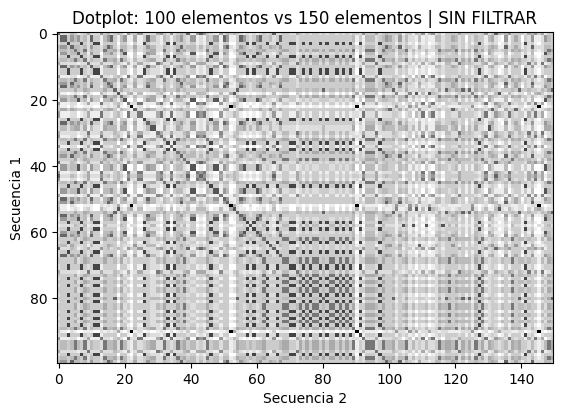

In [109]:
show_dotplot(prot_dotplot)

Grafico filtrado

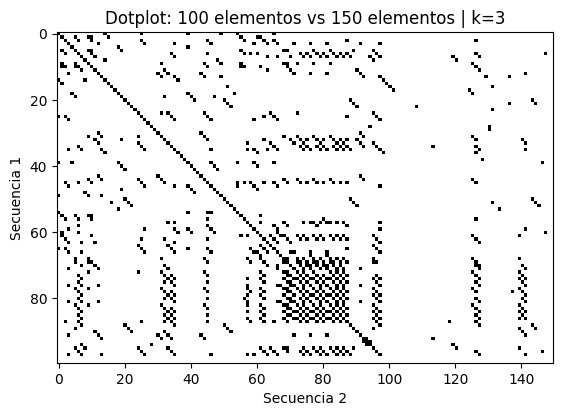

In [110]:
show_dotplot(prot_f_dotplot, prot_k)

Mejor alineamiento

In [41]:
print(prot_align)

M0E1E2P3Q4S5D6P7S8V9E10P11P12L13S14Q15E16T17F18S19D20L21W22K23L24L25P26E27N28N29V30L31S32P33L34P35S36Q37A38M39D40D41L42M43L44S45P46D47D48I49E50Q51W52F53T54E55D56P57G58P59D60E61A62P63R64M65P66E67A68A69P70P71V72A73P74A75P76A77A78P79T80P81A82A83P84A85P86A87P88S89W90------------------------------------------------------W145----


In [42]:
print(score)

380.0


# ALINEAMIENTO MULTIPLE

In [71]:
def align_seq(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2)
    alignment = alignments[0]
    # Calcula la identidad (número de coincidencias sobre el largo)
    identidad = alignment.score / min(len(seq1), len(seq2)) * 100  # Porcentaje de identidad
    return identidad

In [84]:
def d_matrix(seqs):
    n = len(seqs)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            score = align_seq(seqs[i], seqs[j])
            matrix[i, j] = score
    return matrix

In [76]:
def obtain_protein_sequence(prot,k):
    sequences = []
    i = 0
    while i<=(len(prot)-k):
        sequences.append(prot.seq[i:i+k])
        i+=k
    return sequences

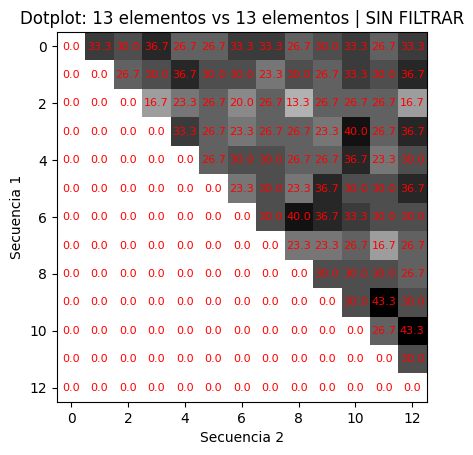

In [114]:
sequences = obtain_protein_sequence(prot,30)

distance_matrix = d_matrix(sequences)
show_dotplot(distance_matrix, show_values=True)